# Vehicle Detection

1. Feature choosing: color based, gradient based
2. Classifier: linear SVM, decision tree, neural network
3. Vehicle searching: sliding window with multiple scale
4. Multiple detection and false positive removal

### Import required libraries

In [50]:
import os
import cv2
import glob
import time
import pickle
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [2]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])

### Load image file names

In [3]:
# load image file names
class_data = [
    {
        'name' : 'Vehicles',
        'base_dir' : 'vehicles/',
        'filenames' : []
    },
    {
        'name' : 'Non-vehicles',
        'base_dir' : 'non-vehicles/',
        'filenames' : []   
    }
]

for data in class_data:
    base_dir = data['base_dir']
    sub_dirs = os.listdir(base_dir)
    for sub_dir in sub_dirs:
        tmpl = base_dir + sub_dir + '/*'
        fnames = glob.glob(tmpl)
        data['filenames'].extend(fnames)
        
print('{}: {} images.'.format(class_data[0]['name'], 
                              len(class_data[0]['filenames'])))
print('{}: {} images.'.format(class_data[1]['name'], 
                              len(class_data[1]['filenames'])))

Vehicles: 8792 images.
Non-vehicles: 8968 images.


## Feature extraction functions

### 1. HOG features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):

    result = hog(img, orientations=orient, 
                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                 cells_per_block=(cell_per_block, cell_per_block), 
                 transform_sqrt=True, 
                 visualise=vis, feature_vector=feature_vec)
    return result

### 2. Binned color features

In [5]:
# Down sampling
def bin_spatial(img, size=(32, 32), skip=False):
    if skip: return []
    features = cv2.resize(img, size).ravel()
    return features

### 3. Color histogram features

In [6]:
def color_hist(img, nbins=32, skip=False):
    if skip: return []
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate(
        (channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Feature extraction

In [9]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
        hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, 
        hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Define a function to extract features from a list of images
    Have this function call bin_spatial() and color_hist()
    """
    args = {
        'color_space' : color_space,
        'spatial_size' : spatial_size,
        'hist_bins' : hist_bins,
        'orient' : orient, 
        'pix_per_cell' : pix_per_cell,
        'cell_per_block' : cell_per_block, 
        'hog_channel' : hog_channel,
        'spatial_feat' : spatial_feat,
        'hist_feat' : hist_feat,
        'hog_feat' : hog_feat
    }
    
    #: all feature vectors
    features = []
    
    # Iterate through the list of images
    for file in imgs:

        file_features = single_img_features(file, **args)
        features.append(file_features)
        
    # Return list of feature vectors
    return features

def single_img_features(file_or_img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis=False):
    clr_conv_func = {
        'RGB'   : lambda img: np.copy(img),
        'HSV'   : lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2HSV),
        'LUV'   : lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2LUV),
        'HLS'   : lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2HLS),
        'YUV'   : lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2YUV),
        'YCrCb' : lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    }
    features = []
    
    image = file_or_img
    if type(file_or_img) in (str, np.str, np.str_):
        image = mpimg.imread(file_or_img)
        if file_or_img.endswith('.jpg'):
            image = image.astype(np.float32)/255
        
    feat_image = clr_conv_func[color_space](image)     

    feats = bin_spatial(feat_image, size=spatial_size, skip=not spatial_feat)
    features.append(feats)

    feats = color_hist(feat_image, nbins=hist_bins, skip=not hist_feat)
    features.append(feats)

    feats = []
    hog_img = None
    for channel in range(feat_image.shape[2]):
        if hog_feat and (hog_channel == 'ALL' or hog_channel == channel):
            result = get_hog_features(feat_image[:,:,channel], orient,
                                      pix_per_cell, cell_per_block, 
                                      vis=vis, feature_vec=True)
            ch_feats = result[0] if len(result) == 2 else result
            hog_img = result[1] if len(result) == 2 else None
            feats.append(ch_feats)
    feats = np.ravel(feats)
    features.append(feats)    

    if vis:
        return np.concatenate(features), hog_img 
    return np.concatenate(features)

### Visualization

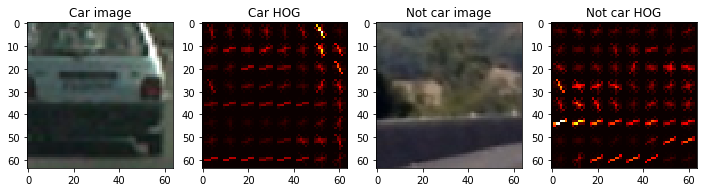

In [10]:
# Read in cars and notcars
cars    = np.array(class_data[0]['filenames'])
notcars = np.array(class_data[1]['filenames'])

car_file = cars[np.random.randint(0, len(cars))]
notcar_file = notcars[np.random.randint(0, len(notcars))]

args = {
    'color_space'    : 'YCrCb',    #: Color space: RGB, HSV, LUV, HLS, YUV, YCrCb
    'spatial_size'   : (32, 32), #: Spatial binning dimensions
    'hist_bins'      : 16,       #: Number of histogram bins

    'orient'         : 9,        #: HOG orientations
    'pix_per_cell'   : 8,        #: HOG pixels per cell
    'cell_per_block' : 2,        #: HOG cells per block
    'hog_channel'    : 0,        #: HOG channel: 0, 1, 2, 'ALL'
    
    'spatial_feat'   : True,     #: Spatial features on or off
    'hist_feat'      : True,     #: histogram features on or off
    'hog_feat'       : True,     #: HOG features on or off
    
    'vis'            : True
}

car_features, car_hog_img = single_img_features(car_file, **args)
notcar_features, notcar_hog_img = single_img_features(notcar_file, **args)

images = [mpimg.imread(car_file), car_hog_img, mpimg.imread(notcar_file), notcar_hog_img]
titles = ['Car image', 'Car HOG', 'Not car image', 'Not car HOG']
fig = plt.figure(figsize=(12, 3))
visualize(fig, 1, 4, images, titles)

## Train classifier

In [11]:
from sklearn.externals import joblib
CLASSIFIER_PICKLE = 'vehicle_classifier.pkl'

# Prepare data
cars    = np.array(class_data[0]['filenames'])
notcars = np.array(class_data[1]['filenames'])

# Extract features
args = {
    'color_space'    : 'YCrCb',    #: Color space: RGB, HSV, LUV, HLS, YUV, YCrCb
    'spatial_size'   : (32, 32), #: Spatial binning dimensions
    'hist_bins'      : 16,       #: Number of histogram bins

    'orient'         : 9,        #: HOG orientations
    'pix_per_cell'   : 8,        #: HOG pixels per cell
    'cell_per_block' : 2,        #: HOG cells per block
    'hog_channel'    : 'ALL',        #: HOG channel: 0, 1, 2, 'ALL'
    
    'spatial_feat'   : True,     #: Spatial features on or off
    'hist_feat'      : True,     #: histogram features on or off
    'hog_feat'       : True,     #: HOG features on or off
}

print('Extracting features...')
t=time.time()
car_features    = extract_features(cars, **args)
notcar_features = extract_features(notcars, **args)
t2 = time.time()
print('Processing time: {} s'.format(round(t2-t, 2)))

# Apply scaler
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack(
    (
        np.ones(len(car_features)), 
        np.zeros(len(notcar_features))
    )
)

# Split up data into randomized training and test sets
rand_state = 98
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Use a linear support vector classifier 
print('Training...')
svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

joblib.dump(svc, CLASSIFIER_PICKLE)

print('Processing time: {} s'.format(round(t2-t, 2)))

# Check the score of the SVC
print('Test Accuracy of SVC = ', 
      round(svc.score(X_test, y_test), 4))


Extracting features...
Processing time: 134.89 s
Feature vector length: 8412
Training...
Processing time: 41.92 s
Test Accuracy of SVC =  0.9887


### Sliding window

In [12]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Define a function that takes an image, start and stop positions 
    in both x and y, window size (x and y dimensions), and overlap 
    fraction (for both x and y)
    """
    # If x and/or y start/stop positions not defined, set to image size
    x_start_stop[0] = x_start_stop[0] or 0
    x_start_stop[1] = x_start_stop[1] or img.shape[1]
    y_start_stop[0] = y_start_stop[0] or 0
    y_start_stop[1] = y_start_stop[1] or img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx   = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy   = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Search from windows

In [13]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
    Define a function you will pass an image 
    and the list of windows to be searched (output of slide_windows())
    """
    args = {
        'color_space' : color_space,
        'spatial_size' : spatial_size,
        'hist_bins' : hist_bins,
        'orient' : orient, 
        'pix_per_cell' : pix_per_cell,
        'cell_per_block' : cell_per_block, 
        'hog_channel' : hog_channel,
        'spatial_feat' : spatial_feat,
        'hist_feat' : hist_feat,
        'hog_feat' : hog_feat
    }
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], 
                                  window[0][0]:window[1][0]], (64, 64))   
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, **args)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

### Heat map

In [53]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, color=(0,0,255), thick=6):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image
    return img

### Visualization

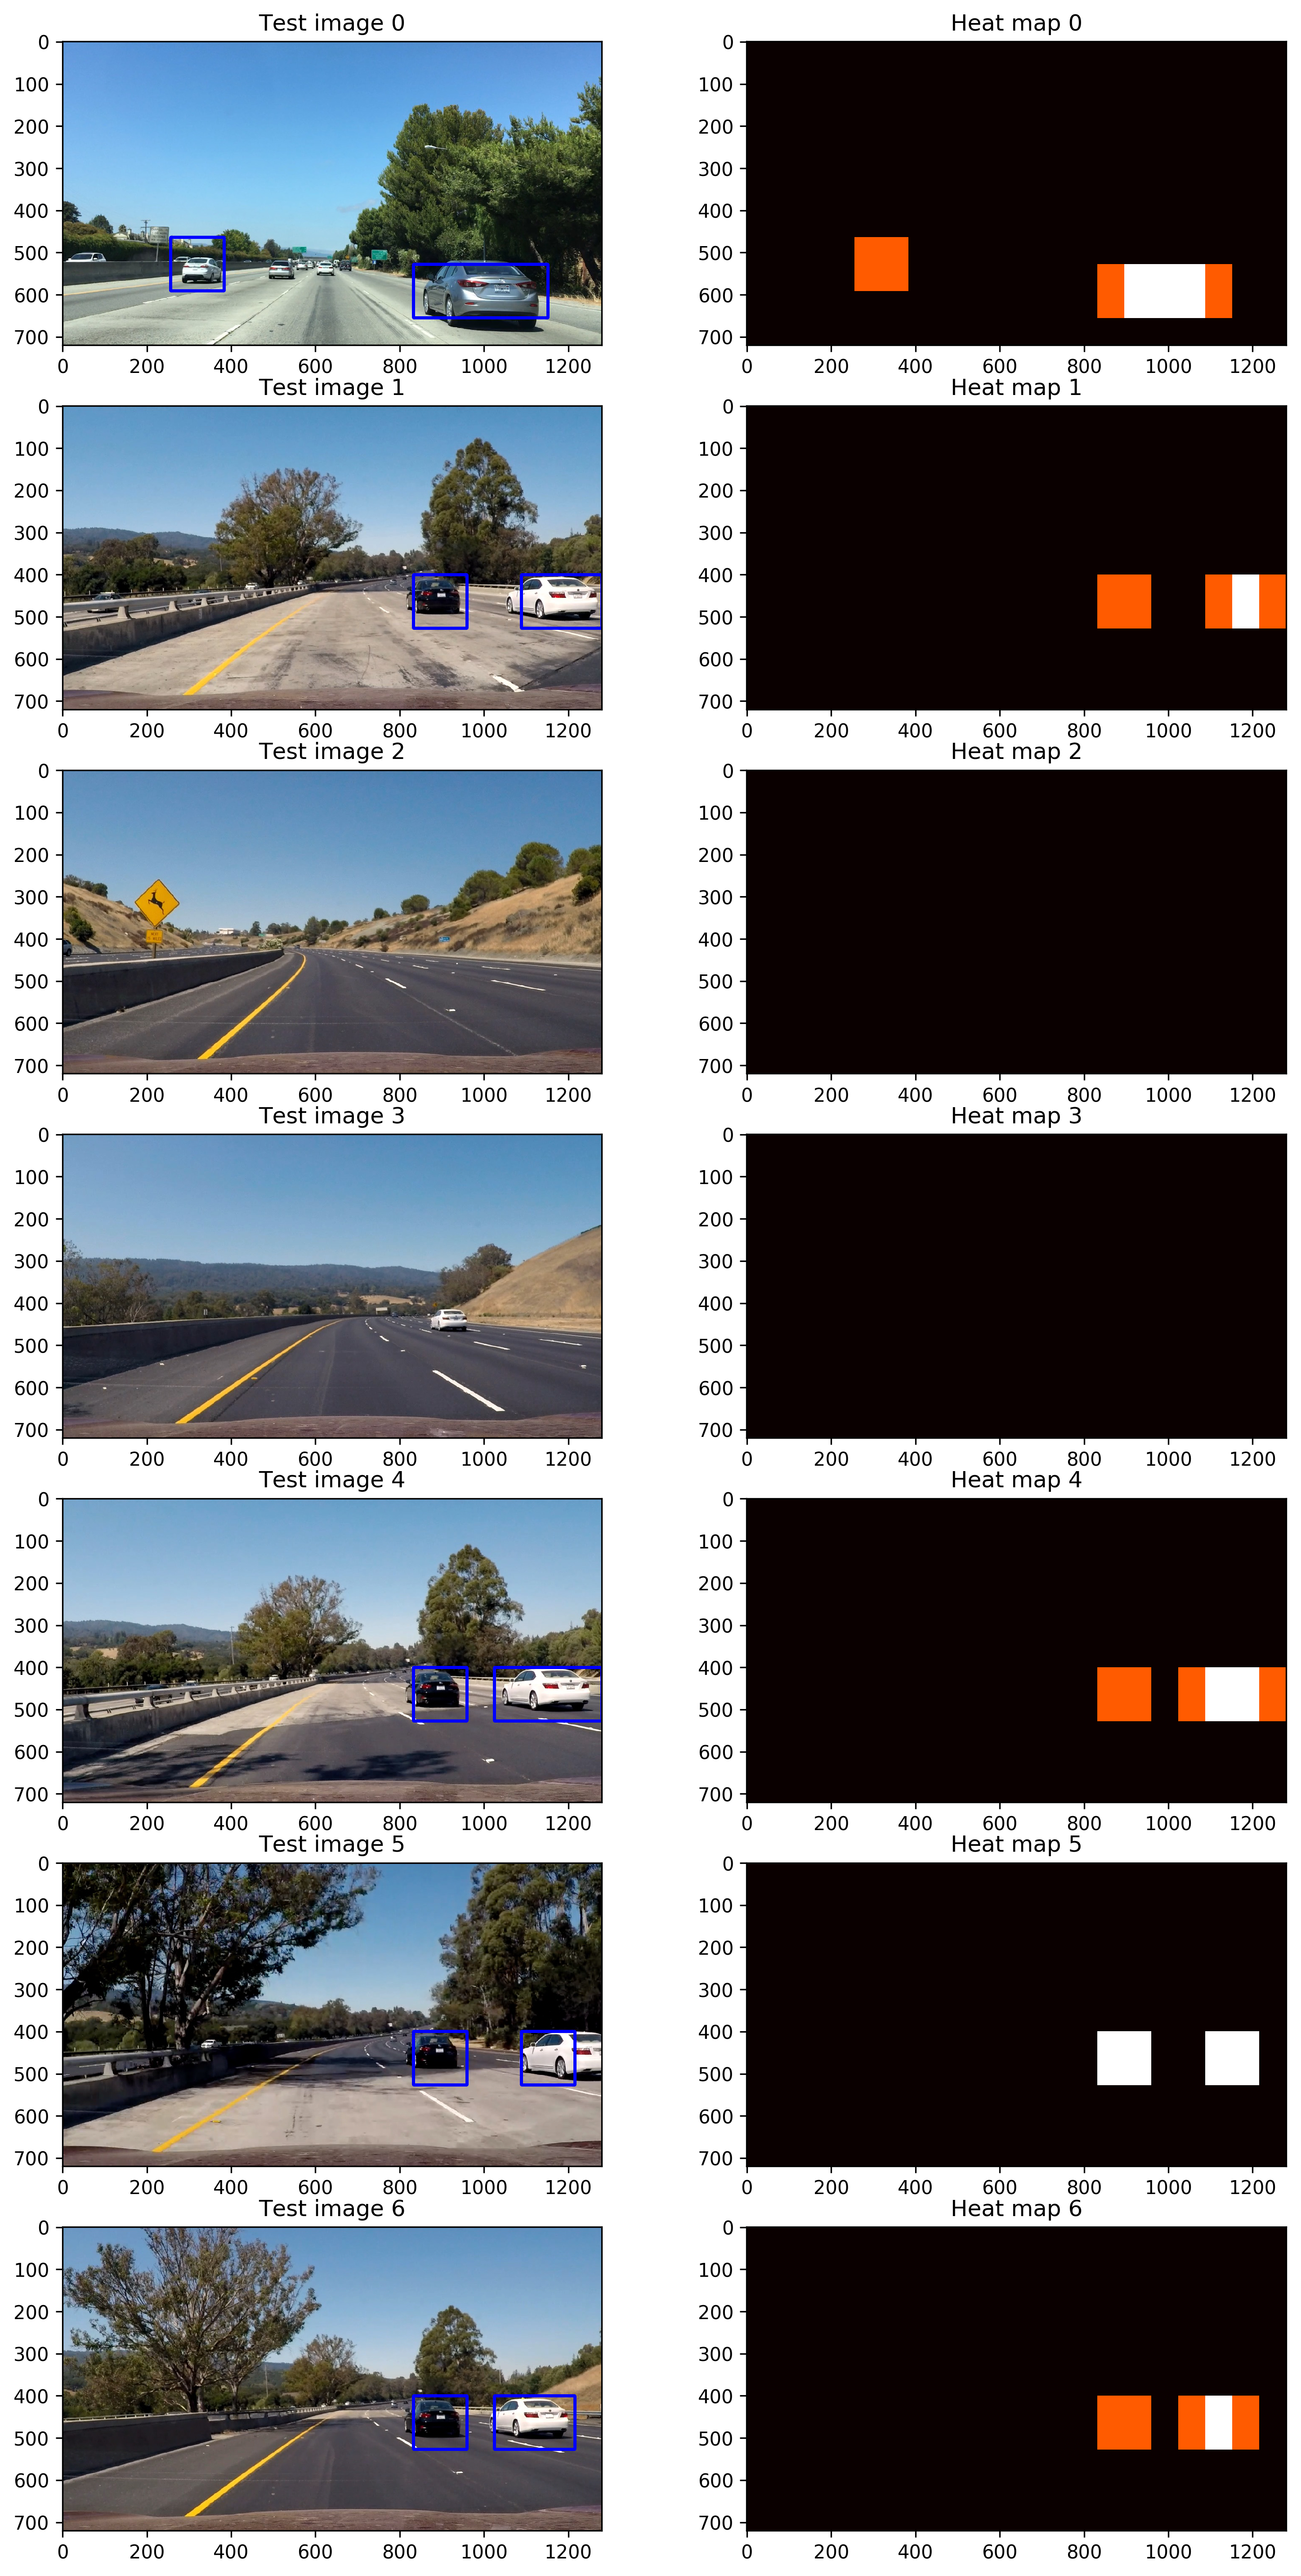

In [52]:
svc = joblib.load(CLASSIFIER_PICKLE)

args = {
    'color_space'    : 'YCrCb',  #: Color space: RGB, HSV, LUV, HLS, YUV, YCrCb
    'spatial_size'   : (32, 32), #: Spatial binning dimensions
    'hist_bins'      : 16,       #: Number of histogram bins

    'orient'         : 9,        #: HOG orientations
    'pix_per_cell'   : 8,        #: HOG pixels per cell
    'cell_per_block' : 2,        #: HOG cells per block
    'hog_channel'    : 'ALL',    #: HOG channel: 0, 1, 2, 'ALL'
    
    'spatial_feat'   : True,     #: Spatial features on or off
    'hist_feat'      : True,     #: histogram features on or off
    'hog_feat'       : True,     #: HOG features on or off
}

slide_win_args = {
    'x_start_stop' : [None, None],
    'y_start_stop' : [400, None],
    'xy_window'    : (128, 128),
    'xy_overlap'   : (0.5, 0.5)
}

images = []
titles = []
for idx, file in enumerate(glob.glob('test_images/*')):
    
    image = mpimg.imread(file)
    draw_image = np.copy(image)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    if file.endswith('.jpg'):
        image = image.astype(np.float32)/255

    # Run sliding window
    windows = slide_window(image, **slide_win_args)
    hot_windows = search_windows(image, windows, svc, X_scaler, **args)
    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    # Add heat map
    heatmap = add_heat(heatmap, hot_windows)
    #heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    
    window_img = draw_labeled_bboxes(draw_image, labels)
    
    images.append(window_img)
    titles.append('Test image {}'.format(idx))
    images.append(heatmap)
    titles.append('Heat map {}'.format(idx))
    
fig = plt.figure(figsize=(12, 28), dpi=300)
visualize(fig, 8, 2, images, titles)


# Video

In [59]:
# Prepare arguments
args = {
    'color_space'    : 'YCrCb',  #: Color space: RGB, HSV, LUV, HLS, YUV, YCrCb
    'spatial_size'   : (32, 32), #: Spatial binning dimensions
    'hist_bins'      : 16,       #: Number of histogram bins

    'orient'         : 9,        #: HOG orientations
    'pix_per_cell'   : 8,        #: HOG pixels per cell
    'cell_per_block' : 2,        #: HOG cells per block
    'hog_channel'    : 'ALL',    #: HOG channel: 0, 1, 2, 'ALL'

    'spatial_feat'   : True,     #: Spatial features on or off
    'hist_feat'      : True,     #: histogram features on or off
    'hog_feat'       : True,     #: HOG features on or off
}

slide_win_args = {
    'x_start_stop' : [None, None],
    'y_start_stop' : [400, None],
    'xy_window'    : (128, 128),
    'xy_overlap'   : (0.5, 0.5)
}

svc = joblib.load(CLASSIFIER_PICKLE)

def process_image(image):

    draw_image = np.copy(image)
    image = image.astype(np.float32) / 255
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Run sliding window
    windows = slide_window(image, **slide_win_args)
    hot_windows = search_windows(image, windows, svc, X_scaler, **args)

    # Add heat map
    heatmap = add_heat(heatmap, hot_windows)
    #heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    
    result = draw_labeled_bboxes(draw_image, labels)
    return result

In [61]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('project_video.mp4')#.subclip(5)
new_clip = clip.fl_image(process_image)
new_clip.write_videofile('project_video_output.mp4', audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [08:56<00:00,  2.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

